# CNN Classifier Training (Supervised Baseline)

Trains a lightweight CNN for supervised defect classification on **NEU Surface Defect** dataset.

**Key Info:**
- 6 defect classes: crazing, inclusion, patches, pitted_surface, rolled-in_scale, scratches
- Supervised classification (not anomaly detection)
- Used as baseline to compare with unsupervised methods

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.insert(0, 'F:/Thesis')

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

from src.config import DEVICE, MODELS_DIR, FIGURES_DIR, NEU_CATEGORIES, ensure_dirs
from src.data import NEUDataset
from src.models import create_cnn_classifier
from src.training import get_optimizer, get_scheduler

ensure_dirs()
print(f"Device: {DEVICE}")
print(f"Classes: {NEU_CATEGORIES}")

Device: cpu
Classes: ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']


## Configuration & Data Loading

In [2]:
CONFIG = {
    'batch_size': 16,
    'num_epochs': 50,
    'learning_rate': 1e-3,
    'weight_decay': 1e-5,
    'num_classes': 6
}

train_dataset = NEUDataset(split='train')
val_dataset = NEUDataset(split='validation')

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=0
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=0
)

print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Train samples: 1440
Validation samples: 360


## Create Model

In [3]:
model = create_cnn_classifier(num_classes=CONFIG['num_classes']).to(DEVICE)
optimizer = get_optimizer(model, lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])
scheduler = get_scheduler(optimizer, patience=3, factor=0.5)
criterion = nn.CrossEntropyLoss()

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Model parameters: 390,918


## Training Loop

In [4]:
history = {'train_loss': [], 'val_loss': [], 'val_acc': []}
best_acc = 0.0

for epoch in tqdm(range(1, CONFIG['num_epochs'] + 1), desc='Training'):
    # Train
    model.train()
    train_loss = 0
    for img, label in train_loader:
        img, label = img.to(DEVICE), label.to(DEVICE)
        optimizer.zero_grad()
        logits = model(img)
        loss = criterion(logits, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # Validate
    model.eval()
    val_loss, correct = 0, 0
    with torch.no_grad():
        for img, label in val_loader:
            img, label = img.to(DEVICE), label.to(DEVICE)
            logits = model(img)
            val_loss += criterion(logits, label).item()
            correct += (logits.argmax(1) == label).sum().item()
    
    avg_train = train_loss / len(train_loader)
    avg_val = val_loss / len(val_loader)
    acc = correct / len(val_dataset)
    
    history['train_loss'].append(avg_train)
    history['val_loss'].append(avg_val)
    history['val_acc'].append(acc)
    
    scheduler.step(avg_val)
    
    if acc > best_acc:
        best_acc = acc
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Train Loss={avg_train:.4f}, Val Loss={avg_val:.4f}, Val Acc={acc:.4f}")

print(f"\nBest validation accuracy: {best_acc:.4f}")

Training:  20%|██        | 10/50 [12:14<47:53, 71.85s/it] 

Epoch 10: Train Loss=0.2785, Val Loss=1.3985, Val Acc=0.6083


Training:  40%|████      | 20/50 [24:05<35:13, 70.46s/it]

Epoch 20: Train Loss=0.1203, Val Loss=0.0558, Val Acc=0.9778


Training:  60%|██████    | 30/50 [35:45<23:16, 69.82s/it]

Epoch 30: Train Loss=0.0772, Val Loss=0.0302, Val Acc=0.9917


Training:  80%|████████  | 40/50 [47:31<11:45, 70.56s/it]

Epoch 40: Train Loss=0.0498, Val Loss=0.0315, Val Acc=0.9889


Training: 100%|██████████| 50/50 [59:17<00:00, 71.15s/it]

Epoch 50: Train Loss=0.0424, Val Loss=0.0173, Val Acc=0.9944

Best validation accuracy: 1.0000


## Training Curves

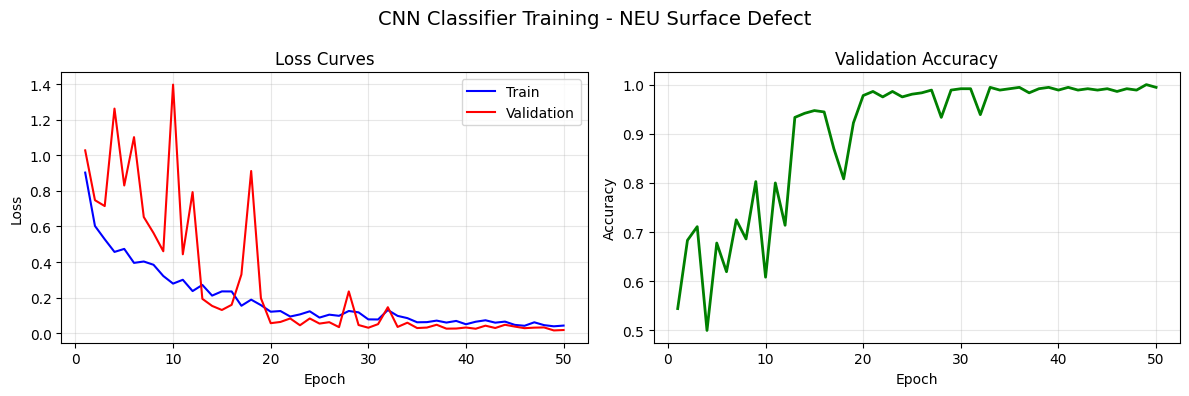

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

epochs = range(1, len(history['train_loss']) + 1)

axes[0].plot(epochs, history['train_loss'], 'b-', label='Train')
axes[0].plot(epochs, history['val_loss'], 'r-', label='Validation')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss Curves')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(epochs, history['val_acc'], 'g-', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Validation Accuracy')
axes[1].grid(True, alpha=0.3)

plt.suptitle('CNN Classifier Training - NEU Surface Defect', fontsize=14)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'cnn_training_curves.png', dpi=150)
plt.show()

## Confusion Matrix & Classification Report

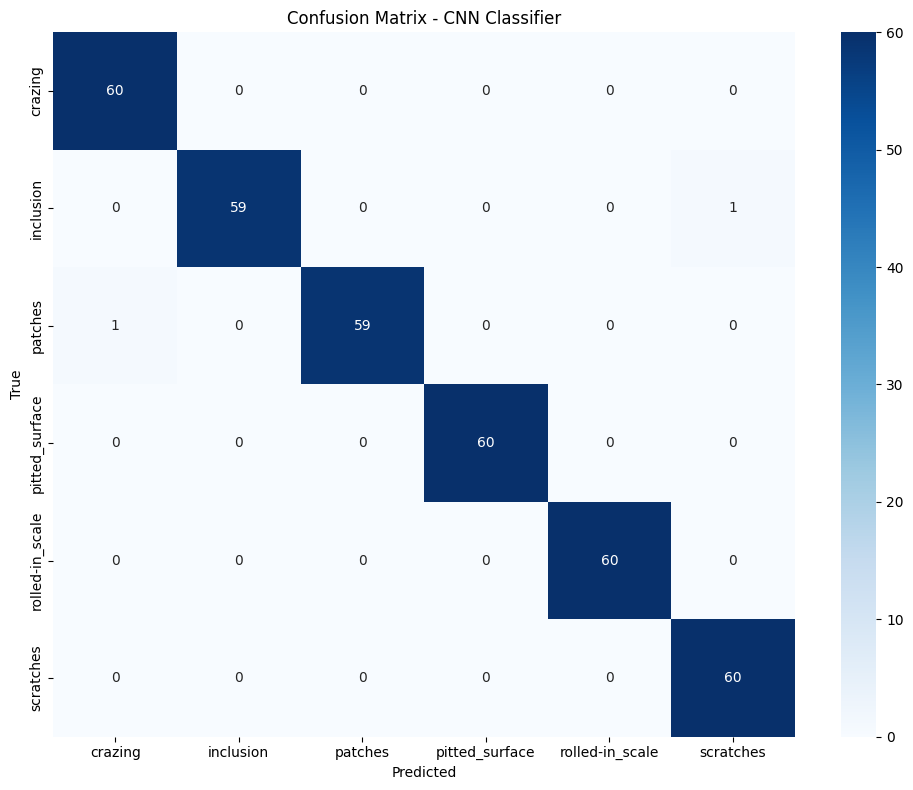


=== Classification Report ===
                 precision    recall  f1-score   support

        crazing       0.98      1.00      0.99        60
      inclusion       1.00      0.98      0.99        60
        patches       1.00      0.98      0.99        60
 pitted_surface       1.00      1.00      1.00        60
rolled-in_scale       1.00      1.00      1.00        60
      scratches       0.98      1.00      0.99        60

       accuracy                           0.99       360
      macro avg       0.99      0.99      0.99       360
   weighted avg       0.99      0.99      0.99       360



In [6]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for img, label in val_loader:
        logits = model(img.to(DEVICE))
        preds = logits.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(label.numpy())

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=NEU_CATEGORIES, yticklabels=NEU_CATEGORIES, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - CNN Classifier')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'cnn_confusion_matrix.png', dpi=150)
plt.show()

# Classification Report
print("\n=== Classification Report ===")
print(classification_report(all_labels, all_preds, target_names=NEU_CATEGORIES))

## Save Model

In [7]:
save_path = MODELS_DIR / 'cnn_classifier_final.pth'

torch.save({
    'model_state_dict': model.state_dict(),
    'config': CONFIG,
    'history': history,
    'accuracy': best_acc,
}, save_path)

print(f"Model saved to: {save_path}")
print(f"\n=== Training Summary ===")
print(f"Epochs: {CONFIG['num_epochs']}")
print(f"Best Accuracy: {best_acc:.4f}")

Model saved to: F:\Thesis\outputs\models\cnn_classifier_final.pth

=== Training Summary ===
Epochs: 50
Best Accuracy: 1.0000
